In [71]:
#Install uninstalled modules, comment if it's already installed

#%pip install -U MetaTrader5 matplotlib numpy pandas pandas_ta scikit-learn

In [72]:
#Python version
!python --version

Python 3.8.12


In [73]:
#Import needed modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta

from datetime import datetime
import os, pytz
import MetaTrader5 as mt5

import config

from sklearn.model_selection import train_test_split
import pickle

In [74]:
#HYPER PARAMETER

In [75]:
#Trading Account Parameter
account = config.username   #Account number
password = config.password  #Password number
server = config.mt5_server  #Server name
path = config.mt5_path      #path of Metatrader5 director

mt5.initialize(
   path = path,          # path to the MetaTrader 5 terminal EXE file
   login = account,      # account number
   password = password,  # password
   server = server,      # server name as it is specified in the terminal
   #timeout = TIMEOUT,   # timeout
   portable = False      # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")
    account_info_dict = mt5.account_info()._asdict()
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(Acc_Info)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.36 

MetaTrader5 Initialized!

 account_info() as dataframe:
              property             value
0                login            647479
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance          99994.96
11              credit               0.0
12              profit               0.0
13              equity          99994.96
14              margin               0.0
15         margin_free          99994.96
16        margin_level               0.0
17      margin_so_call              40.0
18        margin_so_so              20.0
19      margin_initial               0.0

In [76]:
#Extract Account info from dataframe
leverage = Acc_Info.loc[2, "value"]
equity = Acc_Info.loc[13, "value"]
margin_free = Acc_Info.loc[15, "value"]

print(leverage)
print(equity)
print(margin_free)

1000
99994.96
99994.96


In [77]:
# extract information from pair and timeframe
timeframe = config.timeframe
print(timeframe)
symbols = ["EURUSD", "AUDUSD", "GBPUSD"]
print ("------------------------------")
for symbol in symbols:
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info!=None:
        # display the terminal data 'as is'    
        #print(symbol_info)
        print("\n","{}:".format(symbol)," spread =",symbol_info.spread,",  digits =",symbol_info.digits, "\n")
        print ("------------------------------")
    else:
        print("There is no such symbol of {}".format(symbol))

5
------------------------------

 EURUSD:  spread = 10 ,  digits = 5 

------------------------------

 AUDUSD:  spread = 18 ,  digits = 5 

------------------------------

 GBPUSD:  spread = 12 ,  digits = 5 

------------------------------


In [78]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
symbol = 'EURUSD'
timeframe = mt5.TIMEFRAME_M1
bars = 500

rates = mt5.copy_rates_from_pos(symbol, timeframe, 1, bars + 1)

# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))

# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
rates_frame = rates_frame.rename(columns={'tick_volume': 'volume'})
del rates_frame['real_volume']

rates_frame = rates_frame.set_index('time')                           

# display data
print("\nDisplay dataframe with data")
rates_frame.tail()


Display dataframe with data


,open,high,low,close,volume,spread
time,,,,,,
2022-01-07 10:08:00,1.13047,1.13047,1.13006,1.13009,44.0,10.0
2022-01-07 10:09:00,1.13008,1.13030,1.13008,1.13026,56.0,10.0
2022-01-07 10:10:00,1.13026,1.13026,1.13007,1.13007,35.0,10.0
2022-01-07 10:11:00,1.13009,1.13012,1.13004,1.13009,35.0,10.0
2022-01-07 10:12:00,1.13009,1.13019,1.13006,1.13019,19.0,10.0


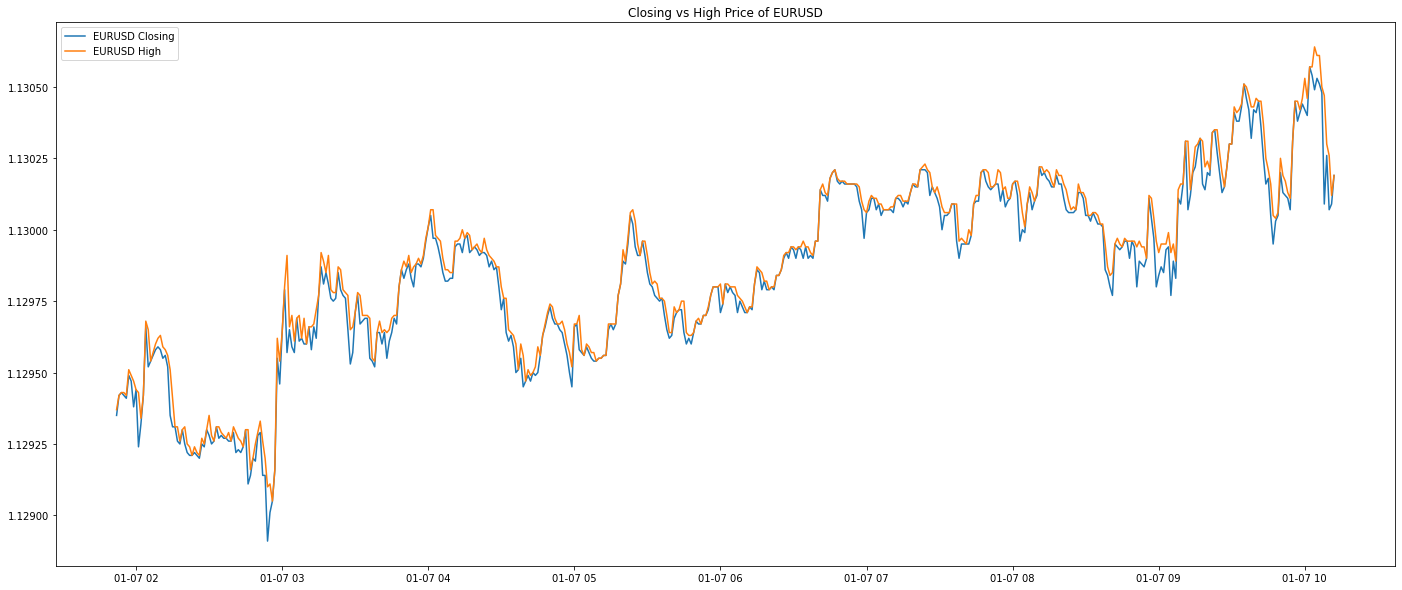

In [79]:
def plotClosing(df):
    plt.figure(figsize=(24,10))
    plt.plot(df.close, label='{} Closing'.format(symbol))
    plt.plot(df.high, label='{} High'.format(symbol))
    plt.title('Closing vs High Price of {}'.format(symbol))
    plt.legend()
    plt.show()

plotClosing(rates_frame)

In [80]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_90'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(window=252).mean().shift(1)
    
    # average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    # average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()

    # oscilator
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

df = generate_features(rates_frame)
df.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
time,,,,,,,,,,,,,,,,,,,,,
2022-01-07 06:05:00,1.12980,1.12978,1.12980,1.12980,1.12978,3.0,1.129768,1.129713,1.129723,1.129617,...,0.633914,0.000018,0.000000,0.000071,0.000115,0.000398,1.190874e-09,0.000002,0.000002,1.12978
2022-01-07 06:06:00,1.12978,1.12980,1.12978,1.12980,1.12978,12.0,1.129782,1.129716,1.129726,1.129618,...,0.645520,-0.000018,0.000062,0.000053,0.000177,0.000319,1.239276e-05,0.000003,0.000001,1.12977
2022-01-07 06:07:00,1.12977,1.12978,1.12977,1.12980,1.12977,5.0,1.129788,1.129722,1.129729,1.129620,...,0.645326,-0.000009,0.000027,0.000115,0.000177,0.000301,5.311411e-06,0.000003,0.000001,1.12971
2022-01-07 06:08:00,1.12971,1.12977,1.12971,1.12977,1.12970,5.0,1.129768,1.129727,1.129732,1.129621,...,0.639995,-0.000053,-0.000089,0.000097,0.000133,0.000257,-1.770245e-05,0.000002,0.000001,1.12975
2022-01-07 06:09:00,1.12975,1.12971,1.12975,1.12976,1.12971,5.0,1.129762,1.129733,1.129734,1.129622,...,0.640327,0.000035,-0.000027,0.000115,0.000142,0.000301,-5.310361e-06,0.000002,0.000001,1.12973


In [81]:
df.tail()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
time,,,,,,,,,,,,,,,,,,,,,
2022-01-07 10:08:00,1.13047,1.13050,1.13048,1.13050,1.13039,18.0,1.130510,1.130314,1.130262,1.130073,...,1.113718,-0.000027,-0.000080,0.000381,0.000478,0.000673,-0.000016,7.587434e-06,2.670301e-06,1.13009
2022-01-07 10:09:00,1.13008,1.13047,1.13009,1.13047,1.13006,44.0,1.130420,1.130320,1.130267,1.130074,...,1.122394,-0.000345,-0.000398,0.000124,0.000283,0.000283,-0.000080,4.499565e-06,1.125678e-06,1.13026
2022-01-07 10:10:00,1.13026,1.13008,1.13026,1.13030,1.13008,56.0,1.130374,1.130331,1.130273,1.130076,...,1.150462,0.000150,-0.000203,0.000204,0.000327,0.000407,-0.000041,5.201378e-06,1.617251e-06,1.13007
2022-01-07 10:11:00,1.13009,1.13026,1.13007,1.13026,1.13007,35.0,1.130282,1.130332,1.130277,1.130077,...,1.148245,-0.000168,-0.000407,0.000018,0.000212,0.000239,-0.000081,3.375974e-06,9.501759e-07,1.13009
2022-01-07 10:12:00,1.13009,1.13009,1.13009,1.13012,1.13004,35.0,1.130198,1.130327,1.130276,1.130078,...,1.148261,0.000018,-0.000372,-0.000097,-0.000018,0.000257,-0.000074,-2.768331e-07,1.020406e-06,1.13019


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2022-01-07 06:05:00 to 2022-01-07 10:12:00
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     248 non-null    float64
 1   open_1                   248 non-null    float64
 2   close_1                  248 non-null    float64
 3   high_1                   248 non-null    float64
 4   low_1                    248 non-null    float64
 5   volume_1                 248 non-null    float64
 6   avg_price_5              248 non-null    float64
 7   avg_price_30             248 non-null    float64
 8   avg_price_90             248 non-null    float64
 9   avg_price_365            248 non-null    float64
 10  ratio_avg_price_5_30     248 non-null    float64
 11  ratio_avg_price_5_90     248 non-null    float64
 12  ratio_avg_price_5_365    248 non-null    float64
 13  ratio_avg_price_30_90    248 non-null    fl